In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

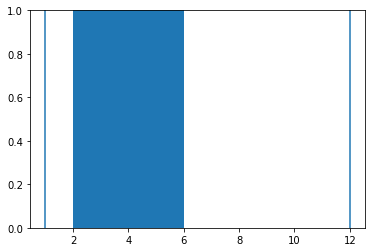

In [7]:
plt.axvline(12)
plt.axvline(1)
plt.axvspan(2, 6)

# Process Information Taken from Raw Files

## Import our Previously Extracted Data

In [8]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [9]:
subject_dataframes = [] # Initialize our dataframe array

for x in tqdm(record_list): # Extract our dataframes from the CSVs we saved previously
    subject_dataframes.append(pd.read_csv('mit-bih-dataframes/'+x+'.csv', index_col=0))
            # 'index_col=0' loads the index that is saved into the csv as the index rather than another column

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]C:\Users\galyn\AppData\Roaming\Python\Python39\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [02:37<00:00,  6.86s/it]


In [31]:

# Now we get the indexes of the R-Peaks from our dataframes
qrs = [] # Initialize the array that will hold our list of R-Peaks for each subject
qrs_colors= []
for subject in tqdm(subject_dataframes): # Load each subject
    qrs.append([idx for idx, x in enumerate(subject['R-Peak']) if x]) # Then we use list comprehension to get our r peaks for each subject
                                                                # Recall, the indices that the R-Peak column is true is where there is an r-peak
                                                                # So, we iterate through and identify which indices that is for each subject
for idx, subj in enumerate(qrs):    
    df_color = []
    for x in subj: 
        if subject_dataframes[idx].loc[x, 'Normal']: 
            df_color.append('green')
        elif subject_dataframes[idx].loc[x, 'AFIB']:
            df_color.append('red')
        else: 
            df_color.append('orange')
    qrs_colors.append(df_color)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.15s/it]


In [34]:
print(len(qrs[1]), len(qrs_colors[1][1:]), len(rr_ints[1]))

61915 61914 61914


## Extract RR-Intervals

In 2019, all of our developed variables were based on RR-Intervals, or the distance between adjacent R-Peaks. So, that is the first thing we extract 

In [12]:
rr_ints = [] # Initialize the array that will hold all of our subjects' RR-Intervals

for idx, subj in enumerate(qrs): # Iterate through our subjects data
    rr1 = [] # Initialize a temporary array that will store a single subject's RR-Intervals
    for idxs, r in enumerate(subj): # Iterate through the subject's R-Peaks
        if idxs == 0: # If it is the first peak we have no interval so go on to the next R-Peak
            next
        else:
            rr1.append(r - subj[idxs-1]) # Find the interval by taking the difference of the location of one R-Peak with the Location of the R-Peak before it
    rr_ints.append(rr1) # Add it to our master array

## Save the RR-Intervals 

In [6]:
reload_flag = False
for idx, subj in enumerate(tqdm(rr_ints)):
    if not os.path.exists("mit-bih-rr-intervalsd/"+record_list[idx]+".csv") or reload_flag:
        np.savetxt("mit-bih-rr-intervals/"+record_list[idx]+".csv", np.array(subj), delimiter=",")

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.86it/s]


## What else to extract - some good places to start

- [Moody, 1983 - A new method for detecting atrial fibrillation using R-R intervals.](http://ecg.mit.edu/george/publications/afib-cinc-1983.pdf)
- [Lake, 2010 - Accurate estimation of entropy in very short physiological time series: the problem of atrial fibrillation detection in implanted ventricular devices](https://journals.physiology.org/doi/full/10.1152/ajpheart.00561.2010)
- [Rubio, 2011 - Estudio comparativo de algoritmos para la deteccion de la fibrilacion auricular](https://academica-e.unavarra.es/bitstream/handle/2454/4136/577570.pdf?sequence=1&isAllowed=y)
- [Ghodrati, 2008 - Statistical analysis of RR interval irregularities for detection of atrial fibrillation](https://ieeexplore.ieee.org/document/4749227)
- [Young, 1999 - A comparative study of a hidden Markov model detector for atrial fibrillation](https://ieeexplore.ieee.org/abstract/document/788166)

## Build Some Initial Plots

In [13]:
rhythm_dics = []
header_dics = []

for x in record_list:
    with open('mit-bih-extracted/'+x+'_rhythms.pkl', mode='rb') as infile:
        rhythm_dics.append(pickle.load(infile))
    with open('mit-bih-extracted/'+x+'_headers.pkl', mode='rb') as infile:
        header_dics.append(pickle.load(infile))
        

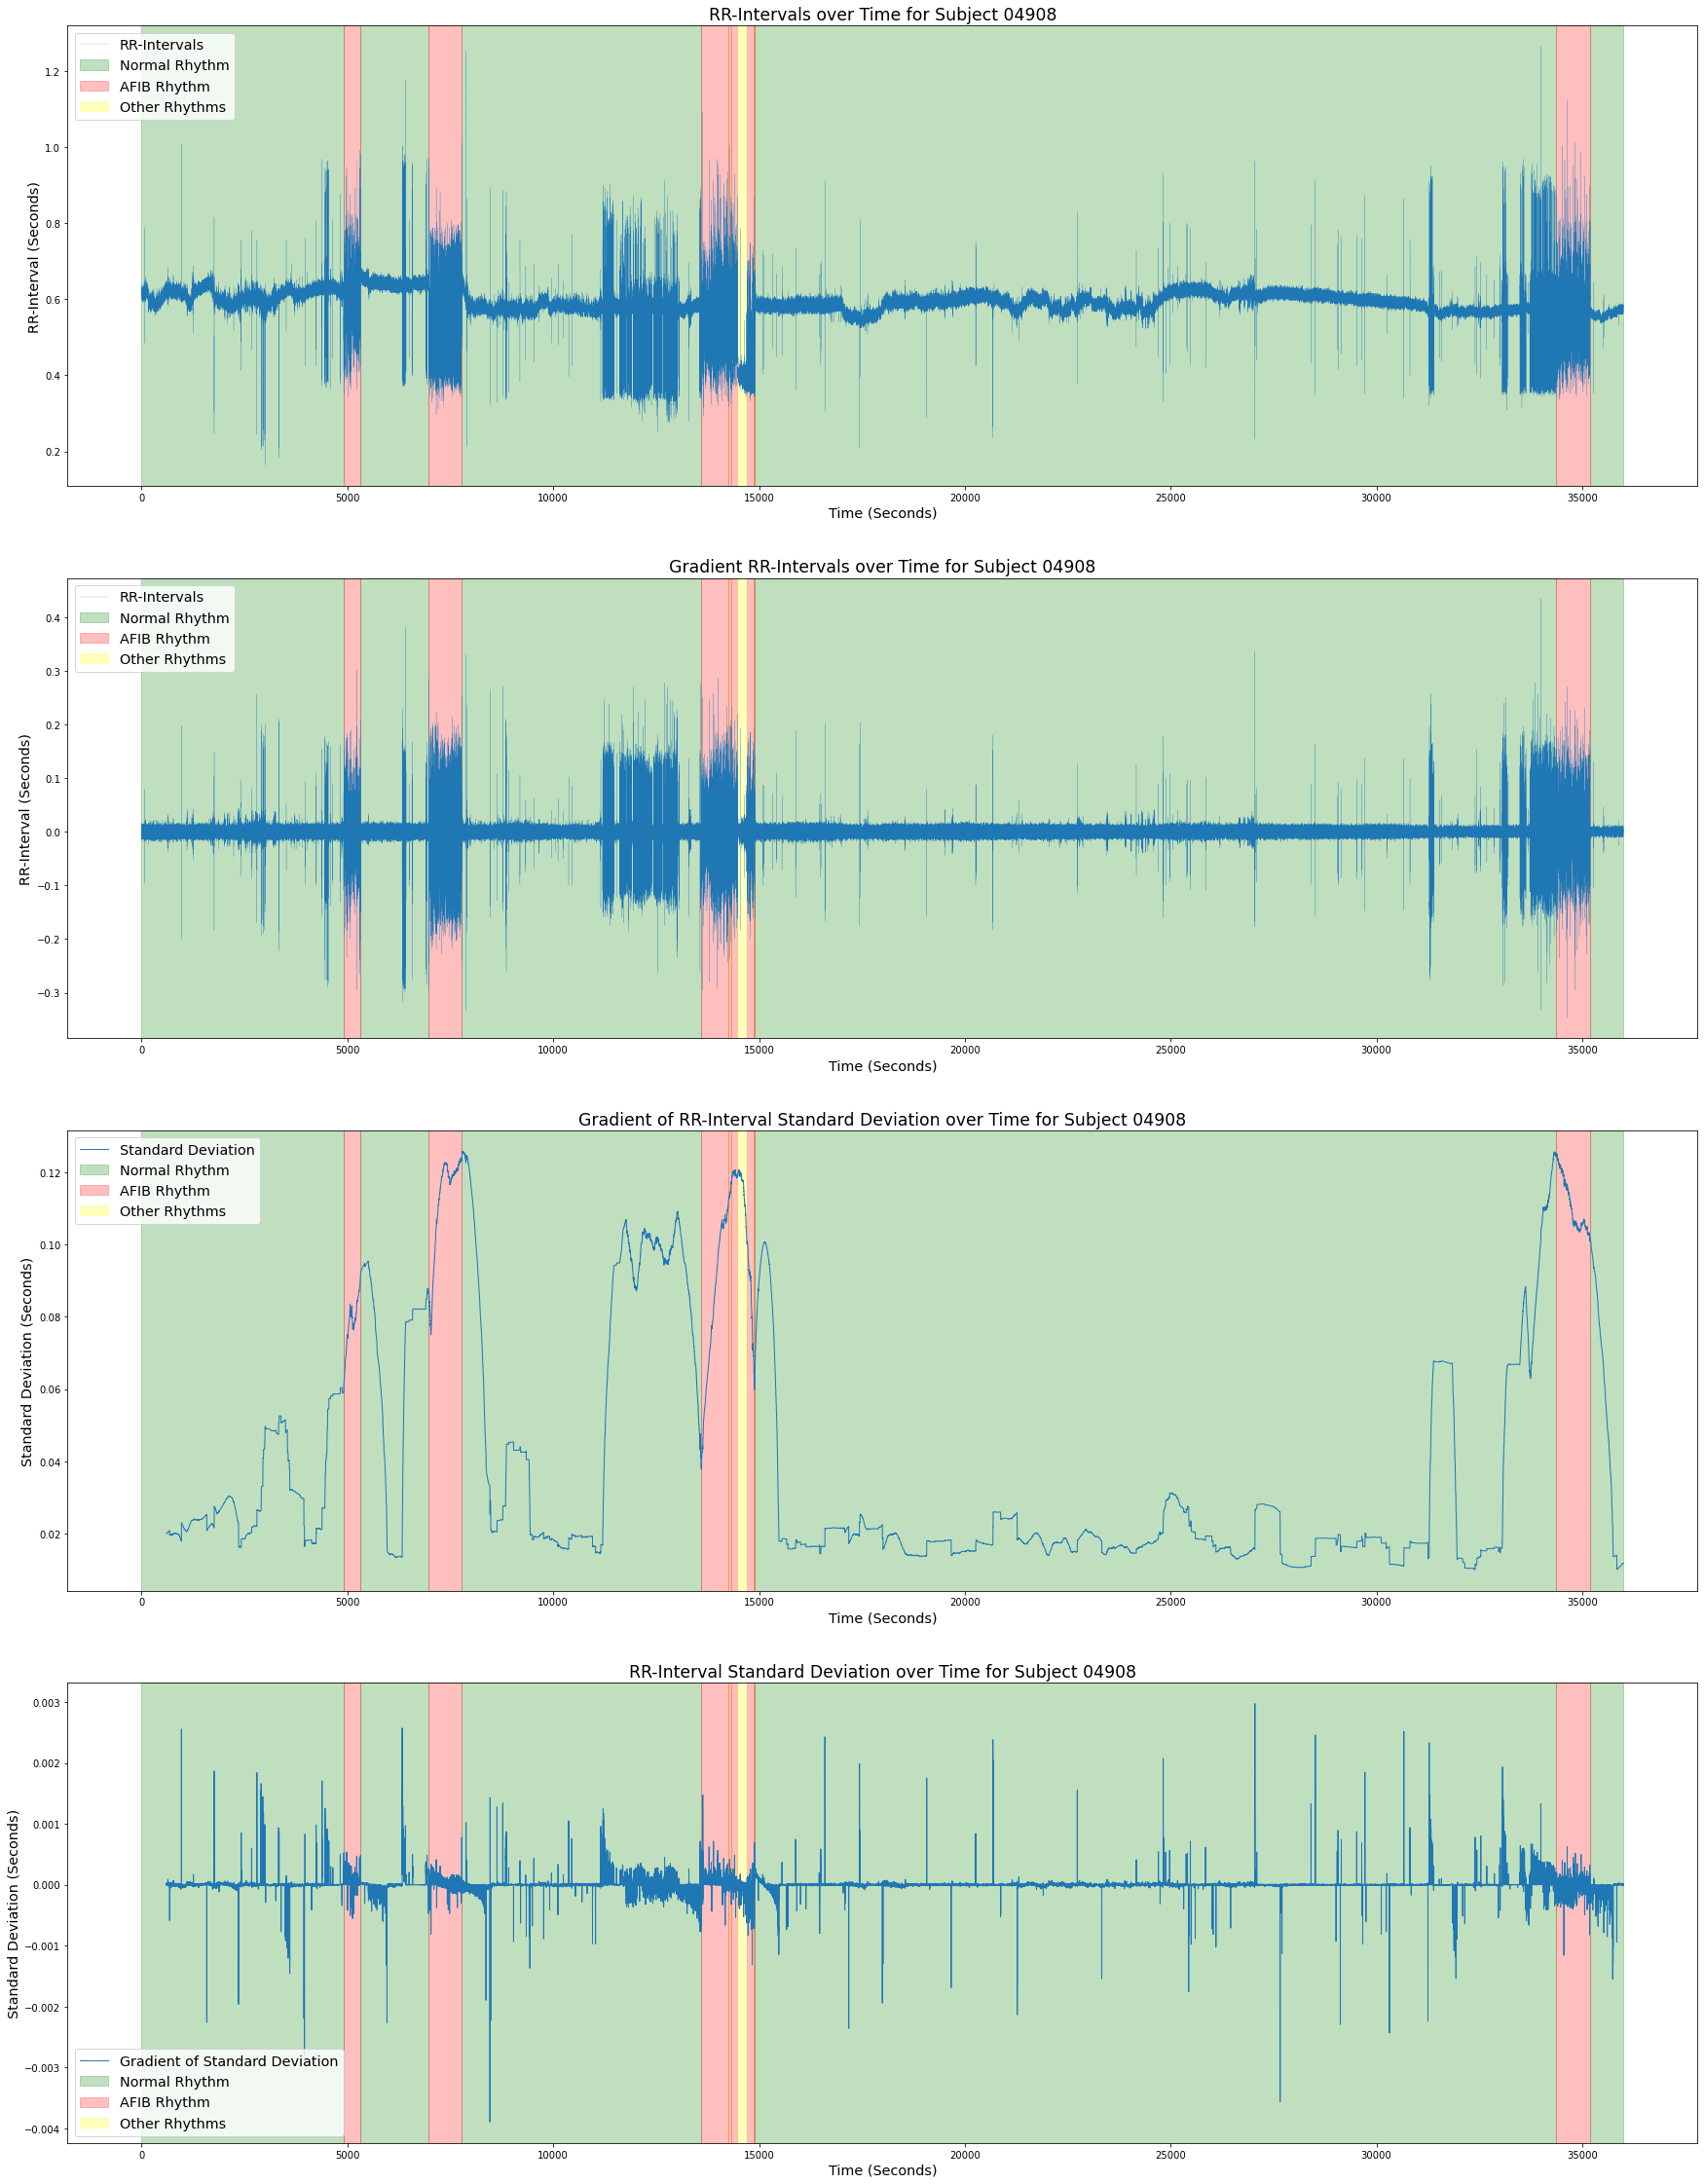

In [46]:
subj = 5
plt.figure(figsize = (30,40))
sp = 4
plt.subplot((sp*100)+11)
for idx, x in enumerate(rhythm_dics[subj]):
    for [a, b] in rhythm_dics[subj][x]:
        a = a / header_dics[subj]['fs'] 
        if b > max(qrs[subj]):
            b = max(qrs[subj])
        b = b / header_dics[subj]['fs'] 
        if x == "(N":
            plt.axvspan(a, b, color = 'green', alpha = .25, label = 'Normal Rhythm')
        elif x == "(AFIB":
            plt.axvspan(a, b, color = 'red', alpha = .25, label = "AFIB Rhythm")
        else:
            plt.axvspan(a, b, color = 'yellow', alpha = .25, label = "Other Rhythms")


plt.plot( [x/header_dics[subj]['fs'] for x in qrs[subj][1:]], [x/header_dics[subj]['fs'] for x in rr_ints[subj]], label = "RR-Intervals", linewidth = .2)

# Below from https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
i =1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1
# End from https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend


plt.title('RR-Intervals over Time for Subject ' + record_list[subj], fontsize = 'xx-large')
plt.ylabel('RR-Interval (Seconds)', fontsize = 'x-large')
plt.xlabel('Time (Seconds)', fontsize = 'x-large')
plt.legend(handles, labels, fontsize = 'x-large')

plt.subplot((sp*100)+12)
for idx, x in enumerate(rhythm_dics[subj]):
    for [a, b] in rhythm_dics[subj][x]:
        a = a / header_dics[subj]['fs'] 
        if b > max(qrs[subj]):
            b = max(qrs[subj])
        b = b / header_dics[subj]['fs'] 
        if x == "(N":
            plt.axvspan(a, b, color = 'green', alpha = .25, label = 'Normal Rhythm')
        elif x == "(AFIB":
            plt.axvspan(a, b, color = 'red', alpha = .25, label = "AFIB Rhythm")
        else:
            plt.axvspan(a, b, color = 'yellow', alpha = .25, label = "Other Rhythms")


plt.plot( [x/header_dics[subj]['fs'] for x in qrs[subj][1:]], np.gradient([x/header_dics[subj]['fs'] for x in rr_ints[subj]]), label = "RR-Intervals", linewidth = .2)

# Below from https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
i =1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1
# End from https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend


plt.title('Gradient RR-Intervals over Time for Subject ' + record_list[subj], fontsize = 'xx-large')
plt.ylabel('RR-Interval (Seconds)', fontsize = 'x-large')
plt.xlabel('Time (Seconds)', fontsize = 'x-large')
plt.legend(handles, labels, fontsize = 'x-large')

plt.subplot((sp*100)+13)
for idx, x in enumerate(rhythm_dics[subj]):
    for [a, b] in rhythm_dics[subj][x]:
        a = a / header_dics[subj]['fs'] 
        if b > max(qrs[subj]):
            b = max(qrs[subj])
        b = b / header_dics[subj]['fs'] 
        if x == "(N":
            plt.axvspan(a, b, color = 'green', alpha = .25, label = 'Normal Rhythm')
        elif x == "(AFIB":
            plt.axvspan(a, b, color = 'red', alpha = .25, label = "AFIB Rhythm")
        else:
            plt.axvspan(a, b, color = 'yellow', alpha = .25, label = "Other Rhythms")
stdev_list = rr_ints[subj][0:999]
stdev = []
for x in rr_ints[subj][1000:]:
    stdev_list.append(x)
    stdev_list = stdev_list[1:]
    stdev.append(np.std(stdev_list))
    
    
plt.plot( [x/header_dics[subj]['fs'] for x in qrs[subj][1001:]], [x/header_dics[subj]['fs'] for x in stdev], label = "Standard Deviation", linewidth = 1)

# Below from https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
i =1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1
# End from https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend


plt.title('Gradient of RR-Interval Standard Deviation over Time for Subject ' + record_list[subj], fontsize = 'xx-large')
plt.ylabel('Standard Deviation (Seconds)', fontsize = 'x-large')
plt.xlabel('Time (Seconds)', fontsize = 'x-large')
plt.legend(handles, labels, fontsize = 'x-large')

plt.subplot((sp*100)+14)
for idx, x in enumerate(rhythm_dics[subj]):
    for [a, b] in rhythm_dics[subj][x]:
        a = a / header_dics[subj]['fs'] 
        if b > max(qrs[subj]):
            b = max(qrs[subj])
        b = b / header_dics[subj]['fs'] 
        if x == "(N":
            plt.axvspan(a, b, color = 'green', alpha = .25, label = 'Normal Rhythm')
        elif x == "(AFIB":
            plt.axvspan(a, b, color = 'red', alpha = .25, label = "AFIB Rhythm")
        else:
            plt.axvspan(a, b, color = 'yellow', alpha = .25, label = "Other Rhythms")

    
    
plt.plot( [x/header_dics[subj]['fs'] for x in qrs[subj][1001:]], np.gradient([x/header_dics[subj]['fs'] for x in stdev]), label = "Gradient of Standard Deviation", linewidth = 1)

# Below from https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
i =1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1
# End from https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend


plt.title('RR-Interval Standard Deviation over Time for Subject ' + record_list[subj], fontsize = 'xx-large')
plt.ylabel('Standard Deviation (Seconds)', fontsize = 'x-large')
plt.xlabel('Time (Seconds)', fontsize = 'x-large')
plt.legend(handles, labels, fontsize = 'x-large')

In [24]:
df_color = []
for x in list(subject_dataframes[1].index): 
    if subject_dataframes[1].loc[x, 'Normal']: 
        df_color.append('green')
    elif subject_dataframes[1].loc[x, 'AFIB']:
        df_color.append('red')
    else: 
        df_color.append('orange')

In [30]:
len(df_color)
len(rr_ints[1])

61914

In [28]:
len(df_color)

9205760

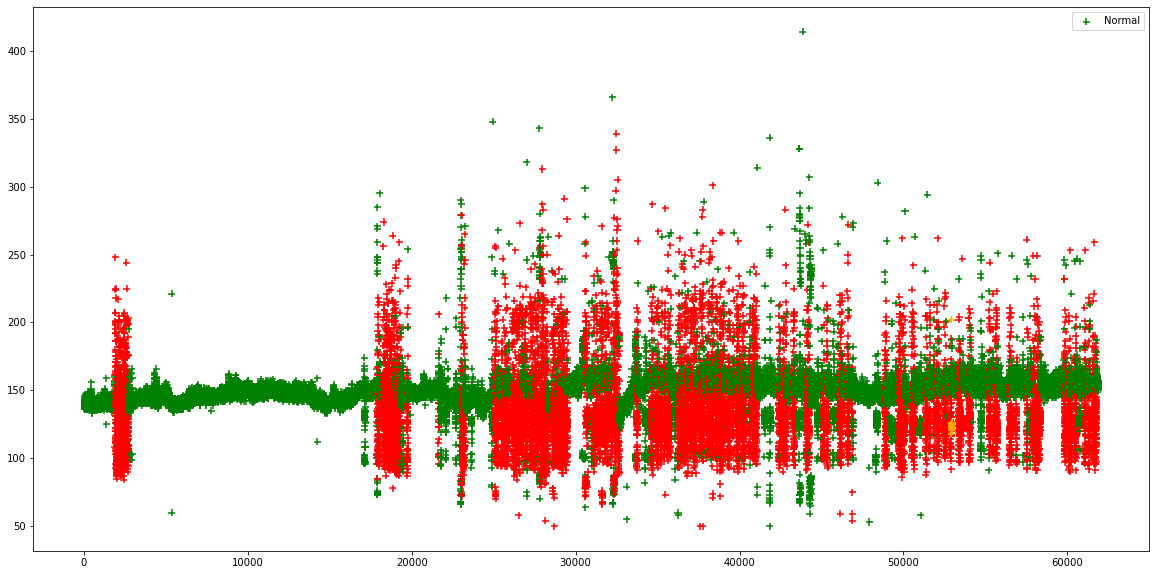

In [50]:
plt.figure(figsize=(20, 10))
plt.scatter(range(len(rr_ints[1])), rr_ints[1], color = qrs_colors[1][1:], s=50, marker = '+')
leg = {
    'Normal': 'green',
    'AFIB': 'red',
    'Other': 'orange'
}
plt.legend(leg)